In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from glob import glob
import os

# Directory where your data files are stored
data_dir = '../data/'

# Find all Excel files for 2024 data
data_files = glob(os.path.join(data_dir, '*_2024_ae_data.xls'))

# Define headers
headers = [
    'Code', 'System', 'Type 1 Departments', 'Type 2 Departments', 'Type 3 Departments',
    'Total Attendances', 'Attendances < 4 hours (Type 1)', 'Attendances < 4 hours (Type 2)',
    'Attendances < 4 hours (Type 3)', 'Total Attendances < 4 hours', 'Attendances > 4 hours (Type 1)',
    'Attendances > 4 hours (Type 2)', 'Attendances > 4 hours (Type 3)', 'Total Attendances > 4 hours',
    'Percentage in 4 hours (all)', 'Percentage in 4 hours (Type 1)', 'Percentage in 4 hours (Type 2)',
    'Percentage in 4 hours (Type 3)', 'Emergency Admissions Type 1', 'Emergency Admissions Type 2',
    'Emergency Admissions Type 3 and 4', 'Total Emergency Admissions via A&E',
    'Other Emergency Admissions (not via A&E)', 'Total Emergency Admissions',
    'Patients spending >4 hours from decision to admit', 'Patients spending >12 hours from decision to admit'
]

# List to store all data
all_data_frames = []

# Read and clean each file
for file in data_files:
    # Extract month name from the filename  ("january_2024_ae_data.xls")
    file_name = os.path.basename(file)
    month_name = file_name.split('_')[0]  # Extract "january" from "january_2024_ae_data.xls"

    # Convert month name to a numeric month
    month_number = pd.to_datetime(month_name + ' 2024', format='%B %Y').month  

    # Read Excel file and skip metadata rows
    data = pd.read_excel(file, engine='xlrd', skiprows=17, header=None, names=headers)

    # Remove invalid rows (e.g., empty or placeholder rows)
    data = data[data['System'].notna() & (data['System'] != '-')]

    # Convert relevant columns to numeric
    numeric_columns = [
        'Total Attendances', 'Total Attendances < 4 hours', 'Total Attendances > 4 hours',
        'Emergency Admissions Type 1', 'Patients spending >4 hours from decision to admit'
    ]
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Drop rows with missing required data
    data = data.dropna(subset=['Total Attendances', 'Total Attendances < 4 hours'])

    # Add 'Month' column based on the filename
    data['Month'] = month_number

    # Add calculated field: Percentage Seen Within 4 Hours
    data['Percentage_Under_4_Hours'] = (data['Total Attendances < 4 hours'] / data['Total Attendances']) * 100

    # Append cleaned data to the list
    all_data_frames.append(data)

# Combine all monthly data into a single DataFrame
combined_data = pd.concat(all_data_frames, ignore_index=True)

# Save the combined dataset
combined_data.to_csv('../data/combined_2024_ae_data.csv', index=False)
print("Combined data saved to '../data/combined_2024_ae_data.csv'.")

# Preview the first few rows
print("\nFinal Combined Data Preview:")
print(combined_data.head())


Combined data saved to '../data/combined_2024_ae_data.csv'.

Final Combined Data Preview:
  Code                                             System  Type 1 Departments  \
0  QOX  NHS Bath And North East Somerset, Swindon And ...             17493.0   
1  QHG  NHS Bedfordshire, Luton And Milton Keynes Inte...             23953.0   
2  QHL  NHS Birmingham And Solihull Integrated Care Board             37306.0   
3  QUY  NHS Bristol, North Somerset And South Gloucest...             23459.0   
4  QU9  NHS Buckinghamshire, Oxfordshire And Berkshire...             34233.0   

   Type 2 Departments  Type 3 Departments  Total Attendances  \
0               355.0             10293.0            28141.0   
1                 0.0             16524.0            40477.0   
2                 0.0             16376.0            53682.0   
3              2252.0              7594.0            33305.0   
4              5268.0              8500.0            48001.0   

   Attendances < 4 hours (Type 1)  Att

In [250]:
# Generate synthetic data with adjusted variance and mean
def generate_synthetic_data(start_date, end_date, freq='h', seed=42):
    idx = pd.date_range(start=start_date, end=end_date, freq=freq)
    rng = np.random.default_rng(seed=seed)
    wait_times = rng.normal(loc=240, scale=120, size=len(idx))  # Increased mean and variance
    wait_times = np.clip(wait_times, 10, 600)  # Ensuring values are within a logical range
    return pd.DataFrame(index=idx, data=wait_times, columns=["wait_time_minutes"])

synthetic_df = generate_synthetic_data(start_date='2024-01-01', end_date='2024-12-31')

# Categorize into Under 4 Hours and Over 4 Hours
synthetic_df['Under_4_Hours'] = (synthetic_df['wait_time_minutes'] <= 240).astype(int)
synthetic_df['Over_4_Hours'] = (synthetic_df['wait_time_minutes'] > 240).astype(int)

# Ensure 'Month' column exists
synthetic_df['Month'] = synthetic_df.index.month

# Define function for seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply season mapping
synthetic_df['season'] = synthetic_df['Month'].map(get_season)

# Define function for day/night
def day_or_night(hour):
    return 'Day' if 7 <= hour < 19 else 'Night'

# Apply day/night feature
synthetic_df['day_or_night'] = synthetic_df.index.hour.map(day_or_night)

# Aggregate by month for comparison
synthetic_monthly = synthetic_df.resample('M').sum()[['Under_4_Hours', 'Over_4_Hours']]
synthetic_monthly['Month'] = synthetic_monthly.index.month
synthetic_monthly.reset_index(drop=True, inplace=True)

# Scale Synthetic Data to Match Real Data Magnitude for Under 4 Hours
real_under4_monthly = combined_data.groupby('Month')[['Total Attendances < 4 hours']].sum().reset_index()
scaling_factor_under4 = real_under4_monthly['Total Attendances < 4 hours'].sum() / synthetic_monthly['Under_4_Hours'].sum()
synthetic_monthly['Under_4_Hours_Scaled'] = synthetic_monthly['Under_4_Hours'] * scaling_factor_under4

# Scale Synthetic Data to Match Real Data Magnitude for Over 4 Hours
real_over4_monthly = combined_data.groupby('Month')[['Total Attendances > 4 hours']].sum().reset_index()
scaling_factor_over4 = real_over4_monthly['Total Attendances > 4 hours'].sum() / synthetic_monthly['Over_4_Hours'].sum()
synthetic_monthly['Over_4_Hours_Scaled'] = synthetic_monthly['Over_4_Hours'] * scaling_factor_over4


/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_86033/3400777152.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  synthetic_monthly = synthetic_df.resample('M').sum()[['Under_4_Hours', 'Over_4_Hours']]


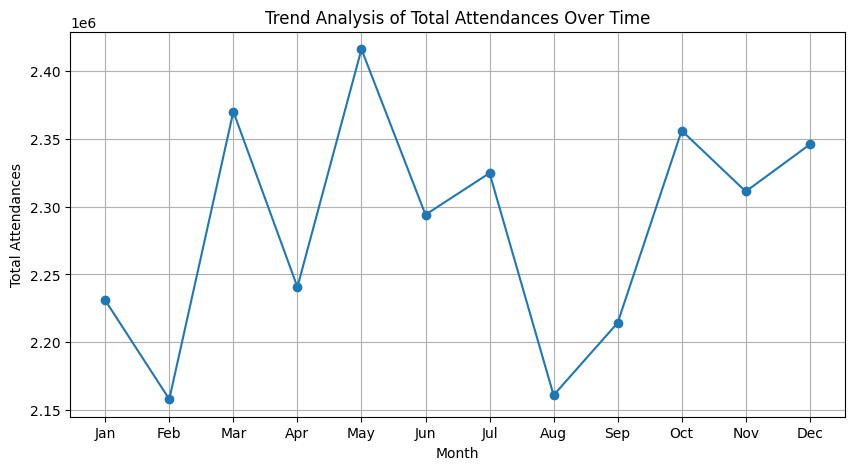

In [251]:
# Plot trend analysis of Total Attendances over time
plt.figure(figsize=(10, 5))
plt.plot(combined_data.groupby('Month')['Total Attendances'].sum(), marker='o')
plt.title("Trend Analysis of Total Attendances Over Time")
plt.xlabel("Month")
plt.ylabel("Total Attendances")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()


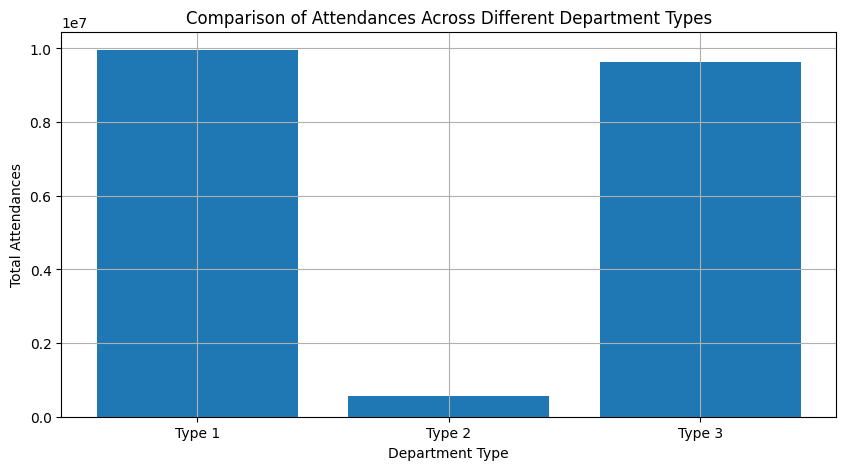

In [252]:
# Aggregate and plot comparison of attendances across different department types
department_types = ['Type 1', 'Type 2', 'Type 3']
total_attendances_types = combined_data[['Attendances < 4 hours (Type 1)', 'Attendances < 4 hours (Type 2)', 'Attendances < 4 hours (Type 3)']].sum()

plt.figure(figsize=(10, 5))
plt.bar(department_types, total_attendances_types)
plt.title("Comparison of Attendances Across Different Department Types")
plt.xlabel("Department Type")
plt.ylabel("Total Attendances")
plt.grid()
plt.show()


In [253]:
# Provide statistical summary of attendances under and over 4 hours
under_4_stats = combined_data['Total Attendances < 4 hours'].describe()
over_4_stats = combined_data['Total Attendances > 4 hours'].describe()

print("\nStatistical Summary of Attendances < 4 Hours:")
print(under_4_stats)

print("\nStatistical Summary of Attendances > 4 Hours:")
print(over_4_stats)



Statistical Summary of Attendances < 4 Hours:
count       504.000000
mean      39938.470238
std       23027.482334
min        8881.000000
25%       23707.250000
50%       31244.000000
75%       52194.500000
max      115118.000000
Name: Total Attendances < 4 hours, dtype: float64

Statistical Summary of Attendances > 4 Hours:
count      504.000000
mean     14472.412698
std       8060.250562
min       3662.000000
25%       8877.500000
50%      12604.500000
75%      17817.250000
max      46991.000000
Name: Total Attendances > 4 hours, dtype: float64


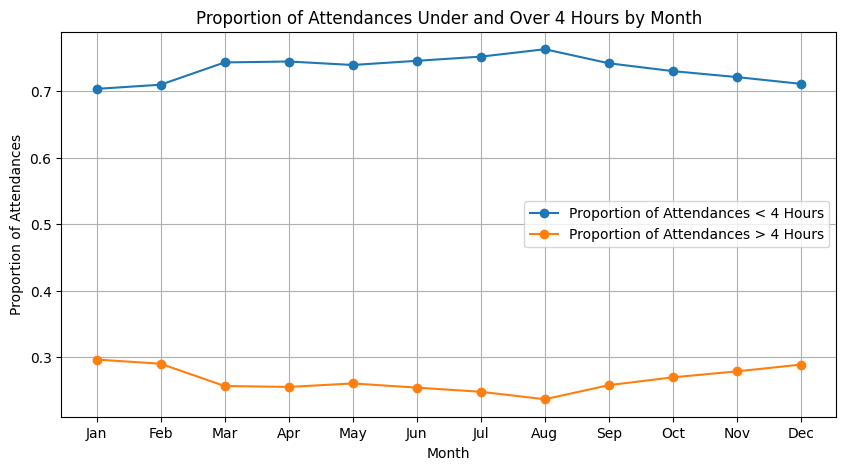

In [254]:
# Calculate and plot the proportion of attendances under and over 4 hours for each month
proportion_under_4_hours = combined_data.groupby('Month')['Total Attendances < 4 hours'].sum() / combined_data.groupby('Month')['Total Attendances'].sum()
proportion_over_4_hours = combined_data.groupby('Month')['Total Attendances > 4 hours'].sum() / combined_data.groupby('Month')['Total Attendances'].sum()

plt.figure(figsize=(10, 5))
plt.plot(proportion_under_4_hours, label="Proportion of Attendances < 4 Hours", marker='o')
plt.plot(proportion_over_4_hours, label="Proportion of Attendances > 4 Hours", marker='o')
plt.title("Proportion of Attendances Under and Over 4 Hours by Month")
plt.xlabel("Month")
plt.ylabel("Proportion of Attendances")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid()
plt.show()


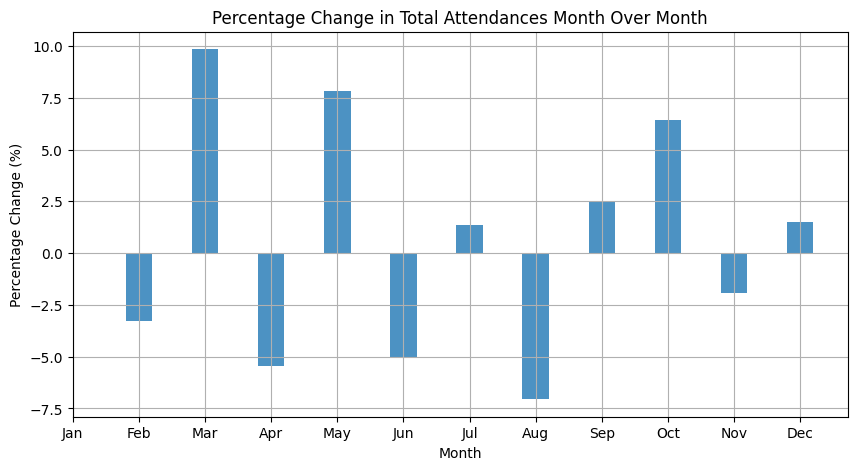

In [255]:
# Calculate percentage change in attendances month over month
combined_data['Total Attendances'] = combined_data['Total Attendances < 4 hours'] + combined_data['Total Attendances > 4 hours']
monthly_attendances = combined_data.groupby('Month')['Total Attendances'].sum()
percentage_change = monthly_attendances.pct_change() * 100

# Plot percentage change in attendances
plt.figure(figsize=(10, 5))
plt.bar(monthly_attendances.index, percentage_change, width=0.4, alpha=0.8)
plt.title("Percentage Change in Total Attendances Month Over Month")
plt.xlabel("Month")
plt.ylabel("Percentage Change (%)")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()
